<a href="https://colab.research.google.com/github/hongjai-rhee/public/blob/master/%EB%AC%B8%EC%9E%A5%ED%95%99%EC%8A%B5_%EC%98%88%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 문장생성 알고리즘
기계가 글을 쓸 수 있을까? 문장은 단어의 sequence이다. 주어진 일부 sequence 뒤에 어떤 단어가 나타날 확률을 알 수 있다면 기계가 문장을 생성하는 것이 가능할 것이다. 간단한 예를 통해 살펴보자.


---

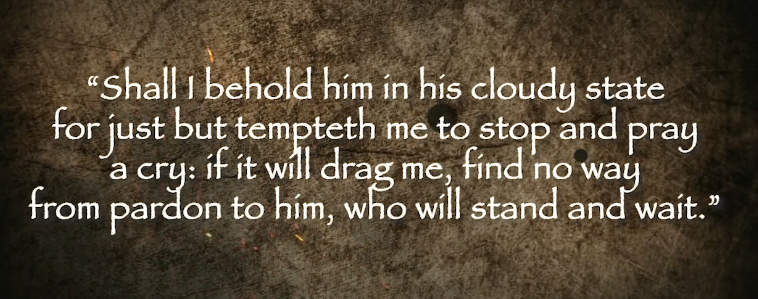

In [0]:
#-*- encoding: utf-8 -*-     ## 한글사용
EPOCH=200


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.utils import to_categorical
text="""경마장에 가는 말이 뛰고 있다\n
경마장에 가는 말이 달리고 있다\n
달리고 오는 말이 지친다\n
가는 말이 고와야 오는 말이 곱다\n"""
print(text)


경마장에 가는 말이 뛰고 있다

경마장에 가는 말이 달리고 있다

달리고 오는 말이 지친다

가는 말이 고와야 오는 말이 곱다



이 코드에서 text 변수는 학습을 위해 사용하는 책이다. 이 책에는 4개의 문장이 수록되어 있다. 세익스피어의 소설을 text로 사용하면 세익스피어를 흉내 낼 수 있다.  

아래 코드는 주어진 책에서 모든 단어를 추출하는 기능을 수행한다. text에는 모두 12개의 단어가 수록되어 있다 (코드 0은 기타).

In [0]:
t = Tokenizer()
t.fit_on_texts([text])
vocab_size = len(t.word_index) + 1
# 케라스 토크나이저의 정수 인코딩은 인덱스가 1부터 시작하지만,
# 케라스 원-핫 인코딩에서 배열의 인덱스가 0부터 시작하기 때문에
# 배열의 크기를 실제 단어 집합의 크기보다 +1로 생성해야하므로 미리 +1 선언 
print('단어 집합의 크기 : %d' % vocab_size)
print(t.word_index)

단어 집합의 크기 : 11
{'말이': 1, '가는': 2, '경마장에': 3, '있다': 4, '달리고': 5, '오는': 6, '뛰고': 7, '지친다': 8, '고와야': 9, '곱다': 10}


Sequence는 text에 주어진 문장을 순서에 따라 아래와 같이 15개로 나눈 것이다. 
1.  경마장에 가는  
2.  경마장에 가는 말이 
3.  경마장에 가는 말이 뛰고 
4.  경마장에 가는 말이 뛰고 있다
5.  경마장에 가는  
6.  경마장에 가는 말이 
7.  경마장에 가는 말이 달리고 
8.  경마장에 가는 말이 달리고 있다
9.  달리고 오는
10. 달리고 오는 말이 
11. 달리고 오는 말이 지친다
12. 가는 말이 고와야 
13. 가는 말이 고와야 오는  
14. 가는 말이 고와야 오는 말이  
15. 가는 말이 고와야 오는 말이 곱다 
 



In [0]:
sequences = list()
for line in text.split('\n'): # Wn을 기준으로 문장 토큰화
    encoded = t.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)

print('학습에 사용할 샘플의 개수: %d' % len(sequences))

학습에 사용할 샘플의 개수: 16


In [0]:
print(sequences)

[[3, 2], [3, 2, 1], [3, 2, 1, 7], [3, 2, 1, 7, 4], [3, 2], [3, 2, 1], [3, 2, 1, 5], [3, 2, 1, 5, 4], [5, 6], [5, 6, 1], [5, 6, 1, 8], [2, 1], [2, 1, 9], [2, 1, 9, 6], [2, 1, 9, 6, 1], [2, 1, 9, 6, 1, 10]]


Sequence중 가장 긴 것은 6개의 단어를 포함하고 있다 

In [0]:
max_len=max(len(l) for l in sequences) # 모든 샘플에서 길이가 가장 긴 샘플의 길이 출력
print('샘플의 최대 길이 : {}'.format(max_len))

샘플의 최대 길이 : 6


# Padding
데이터의 필드를 6개로 맞추기 위해 [3,2]을 [0,0,0,0,3,2]로 맞추어 준다 (부족한 곳은 0을 넣어 패딩)


In [0]:
sequences =np.array(pad_sequences(sequences, maxlen=max_len, padding='pre'))


In [0]:
print(sequences)

[[ 0  0  0  0  3  2]
 [ 0  0  0  3  2  1]
 [ 0  0  3  2  1  7]
 [ 0  3  2  1  7  4]
 [ 0  0  0  0  3  2]
 [ 0  0  0  3  2  1]
 [ 0  0  3  2  1  5]
 [ 0  3  2  1  5  4]
 [ 0  0  0  0  5  6]
 [ 0  0  0  5  6  1]
 [ 0  0  5  6  1  8]
 [ 0  0  0  0  2  1]
 [ 0  0  0  2  1  9]
 [ 0  0  2  1  9  6]
 [ 0  2  1  9  6  1]
 [ 2  1  9  6  1 10]]


# 학습데이터 만들기
Sequence의 마지막 필드를 y로 나머지를 X로 저장한다


In [0]:
sequences = np.array(sequences)
X = sequences[:,:-1]
y = sequences[:,-1]
# 리스트의 마지막 값을 제외하고 저장한 것은 X
# 리스트의 마지막 값만 저장한 것은 y. 이는 레이블에 해당됨.

In [0]:
print(X) ## 앞의 단어 sequence


[[0 0 0 0 3]
 [0 0 0 3 2]
 [0 0 3 2 1]
 [0 3 2 1 7]
 [0 0 0 0 3]
 [0 0 0 3 2]
 [0 0 3 2 1]
 [0 3 2 1 5]
 [0 0 0 0 5]
 [0 0 0 5 6]
 [0 0 5 6 1]
 [0 0 0 0 2]
 [0 0 0 2 1]
 [0 0 2 1 9]
 [0 2 1 9 6]
 [2 1 9 6 1]]


In [0]:
print(y)  ## 뒤에 오는 단어

[ 2  1  7  4  2  1  5  4  6  1  8  1  9  6  1 10]


y는 단어의 카테고리를 나타내므로, one-hot 인코딩한다.

In [0]:
y = to_categorical(y, num_classes=vocab_size)
print(y)


[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# 모형설정
softmax 분류모델을 만들어 실행하자. 특히 문맥을 파악하기 위해, 단어의 배열 순서가 중요하므로 RNN 레이어를 사용한다. 


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=max_len-1)) # 레이블을 분리하였으므로 이제 X의 길이는 5
model.add(SimpleRNN(16))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=EPOCH, verbose=2)


Train on 16 samples
Epoch 1/200
16/16 - 0s - loss: 2.4097 - acc: 0.0000e+00
Epoch 2/200
16/16 - 0s - loss: 2.4016 - acc: 0.0625
Epoch 3/200
16/16 - 0s - loss: 2.3938 - acc: 0.1250
Epoch 4/200
16/16 - 0s - loss: 2.3861 - acc: 0.1250
Epoch 5/200
16/16 - 0s - loss: 2.3785 - acc: 0.1250
Epoch 6/200
16/16 - 0s - loss: 2.3711 - acc: 0.1250
Epoch 7/200
16/16 - 0s - loss: 2.3638 - acc: 0.1875
Epoch 8/200
16/16 - 0s - loss: 2.3565 - acc: 0.1875
Epoch 9/200
16/16 - 0s - loss: 2.3492 - acc: 0.1875
Epoch 10/200
16/16 - 0s - loss: 2.3418 - acc: 0.1875
Epoch 11/200
16/16 - 0s - loss: 2.3344 - acc: 0.3125
Epoch 12/200
16/16 - 0s - loss: 2.3270 - acc: 0.3125
Epoch 13/200
16/16 - 0s - loss: 2.3194 - acc: 0.3125
Epoch 14/200
16/16 - 0s - loss: 2.3117 - acc: 0.3125
Epoch 15/200
16/16 - 0s - loss: 2.3039 - acc: 0.3125
Epoch 16/200
16/16 - 0s - loss: 2.2959 - acc: 0.3125
Epoch 17/200
16/16 - 0s - loss: 2.2877 - acc: 0.3125
Epoch 18/200
16/16 - 0s - loss: 2.2794 - acc: 0.3125
Epoch 19/200
16/16 - 0s - loss:

# 예측하기
시작 단어를 주고, 생성 단어 개수를 입력하면 컴퓨터가 문장을 만들어준다.
 


아래 함수는 처음 단어 하나와 단어생성 개수 K를 입력하면, 학습된 모형의 예측치를 사용하여 K개의 후속단어를 순차적으로 뽑아주는 기능을 수행한다.   

In [0]:
def sentence_generation(model, t, current_word, n): # 모델, 토크나이저, 현재 단어, 반복할 횟수
    init_word = current_word # 처음 들어온 단어도 마지막에 같이 출력하기위해 저장
    sentence = ''
    for _ in range(n): # n번 반복
        encoded = t.texts_to_sequences([current_word])[0] # 현재 단어에 대한 정수 인코딩
        encoded = pad_sequences([encoded], maxlen=max_len-1, padding='pre') # 데이터에 대한 패딩
        result = model.predict_classes(encoded, verbose=0)
    # 입력한 X(현재 단어)에 대해서 Y를 예측하고 Y(예측한 단어)를 result에 저장.
        for word, index in t.word_index.items(): 
            if index == result: # 만약 예측한 단어와 인덱스와 동일한 단어가 있다면
                break # 해당 단어가 예측 단어이므로 break
        current_word = current_word + ' '  + word # 현재 단어 + ' ' + 예측 단어를 현재 단어로 변경
        sentence = sentence + ' ' + word # 예측 단어를 문장에 저장
    # for문이므로 이 행동을 다시 반복
    sentence = init_word + sentence
    return sentence

print(sentence_generation(model, t, '가는', 10))
print(sentence_generation(model, t, '오는', 10))




가는 말이 고와야 오는 말이 곱다 있다 말이 곱다 말이 뛰고
오는 말이 말이 가는 말이 고와야 오는 말이 곱다 있다 말이


**아직** 단어갯수와 패턴인식에 대한 학습이 미진함 ㅎㅎ

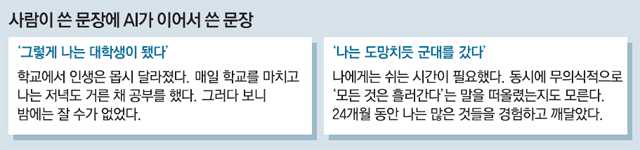